In [1]:
import numpy as np
import pickle
import tensorflow as tf

In [7]:
class PMF(tf.keras.Model):
    def __init__(self, n_users, n_items, n_dim):
        super(PMF, self).__init__()
        ## initializing attributes from parameters        
        self.w_u_i_init = tf.keras.initializers.RandomUniform(minval=-1., maxval=1., seed=1)
        
        ## initializing user embedding layer
        ## the output shape should be n_users * n_dim
        self.user_embedding = tf.keras.layers.Embedding(n_users,
                                                        n_dim,
                                                        embeddings_initializer='uniform',
                                                        embeddings_regularizer=tf.keras.regularizers.L2(0.1))
        ## initializing user embedding layer
        ## the output shape should be n_items * n_dim
        self.item_embedding = tf.keras.layers.Embedding(n_items,
                                                        n_dim,
                                                        embeddings_initializer='uniform',
                                                        embeddings_regularizer=tf.keras.regularizers.L2(0.1))
        
        ## users embedding
        self.ub = tf.keras.layers.Embedding(n_users, 
                                            1, 
                                            embeddings_initializer=self.w_u_i_init, 
                                            embeddings_regularizer=tf.keras.regularizers.L2(0.1))
        
        ## items embedding
        self.ib = tf.keras.layers.Embedding(n_items, 
                                            1, 
                                            embeddings_initializer=self.w_u_i_init, 
                                            embeddings_regularizer=tf.keras.regularizers.L2(0.1))
        
    def call(self, user_index, item_index):
        ## get the user and item embedding value
        user_h1 = self.user_embedding(user_index)
        item_h1 = self.item_embedding(item_index)
        ## should be checked again
        r_h = tf.math.reduce_sum(user_h1 * item_h1, axis=1 if len(user_h1.shape) > 1 else 0)
        r_h += tf.squeeze(self.ub(user_index))
        r_h += tf.squeeze(self.ib(item_index))
        return r_h

In [9]:
print('===== TRAINING PMF =====')
## initializing hyperparameters
batch_size = 64
epoches = 1000
seed = 1
weight_decay = 0.1
emb_dim = 100
ratio = 0.8
lr = 1e-3
momentum = 0.9

## loading dataset
users = pickle.load(open('dataset/user_id_to_num.pkl', 'rb'))
items = pickle.load(open('dataset/item_id_to_num.pkl', 'rb'))
data = np.load('dataset/data_RL_8000.npy')

print("===== Dataset has been loaded =====")

## As the paper implemented, normalizing the rating
## that will act as reward
data[:, 2] = 0.5 * (data[:, 2] - 3)

## Shuffle data
np.random.shuffle(data)
 
## Splitting data data
train_data = data[:int(ratio * data.shape[0])]
vali_data = data[int(ratio * data.shape[0]):int((ratio + (1 - ratio) / 2) * data.shape[0])]
test_data = data[int((ratio + ( 1 - ratio ) / 2) * data.shape[0]):]
 
## Extract number of users and items
NUM_USERS = len(users)
NUM_ITEMS = len(items)

train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).batch(batch_size)
print("===== Preprocess the data has been finished =====")

model = PMF(NUM_USERS, NUM_ITEMS, emb_dim)
model(1, 1)

print("===== Model Instantiated =====")
model.summary()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

def train(train_dataset, len_dataset):
    
    epoch_loss = 0.0
    
    for step, elem in enumerate(train_dataset):
        row = elem[:, 0] ## users as a row
        col = elem[:, 1] ## items as a column
        val = elem[:, 2] ## normalized ratings as value
        
        with tf.GradientTape() as tape:
            
            ## Perlu diperiksa kembali
            row = tf.Variable(row, trainable=False)
            col = tf.Variable(col, trainable=False)
            val = tf.Variable(val, trainable=False)
            
            ## run the forward pass
            logits = model(row, col, training=True)
            
            ## compute the loss value
            loss_value = loss_fn(val, logits)
            
        ## using gradien tape to automatically retrieves
        ## the gradients of the trainable variables with respect to loss
        grads = tape.gradient(loss_value, model.trainable_weights)
        
        ## run one step of gradient descent by updating
        ## the value of variable loss
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        epoch_loss += loss_value
        
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
    
    return float(loss_value)
    
print("===== Training Model =====")
## this list is used for visualization
train_loss_list = []
train_rmse_list = []
vali_rmse_list = []
len_train_data = len(train_data)

last_vali_rmse = None

for epoch in range(epoches):
    ## train epoch losses
    print("\nStart of epoch %d" % (epoch,))
    
    train_epoch_loss = train(train_dataset, len_train_data)
    
    ## test 
    train_loss_list.append(train_epoch_loss)
    
    ## creating index for predicting
    vali_row = tf.Variable(tf.convert_to_tensor(vali_data[:, 0]), trainable=False)
    vali_col = tf.Variable(tf.convert_to_tensor(vali_data[:, 1]), trainable=False)
    
    ## predicting the value
    vali_preds = model(vali_row, vali_col, training=False)
    
    ## calculating rmse
    train_rmse = np.sqrt(train_epoch_loss)
    vali_rmse = np.sqrt(np.square(np.subtract(vali_data[:, 2], vali_preds)).mean())
    
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)
    
    print('Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}'.format(epoch+1, train_rmse, vali_rmse))
    
    if last_vali_rmse and last_vali_rmse < 0.4:
        break
    else:
        last_vali_rmse = vali_rmse

print("===== Testing Model =====")
test_row = tf.Variable(tf.convert_to_tensor(test_data[:, 0]), trainable=False)
test_col = tf.Variable(tf.convert_to_tensor(test_data[:, 1]), trainable=False)

preds = model(test_row, test_col, training=False)

test_rmse = np.sqrt(np.square(np.subtract(test_data[:, 2], vali_preds)).mean())
print('Test rmse: {:f}'.format(test_rmse))

===== TRAINING PMF =====
===== Dataset has been loaded =====
===== Preprocess the data has been finished =====
===== Model Instantiated =====
Model: "pmf_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    multiple                  55000     
                                                                 
 embedding_13 (Embedding)    multiple                  12900     
                                                                 
 embedding_14 (Embedding)    multiple                  550       
                                                                 
 embedding_15 (Embedding)    multiple                  129       
                                                                 
Total params: 68,579
Trainable params: 68,579
Non-trainable params: 0
_________________________________________________________________
===== Training Model =====

Start of epoch 0
Tr

Training epoch: 55, training rmse: 0.461045, vali rmse:0.689847

Start of epoch 55
Training loss (for one batch) at step 0: 0.4538
Training epoch: 56, training rmse: 0.456914, vali rmse:0.687369

Start of epoch 56
Training loss (for one batch) at step 0: 0.4498
Training epoch: 57, training rmse: 0.452867, vali rmse:0.684933

Start of epoch 57
Training loss (for one batch) at step 0: 0.4459
Training epoch: 58, training rmse: 0.448903, vali rmse:0.682536

Start of epoch 58
Training loss (for one batch) at step 0: 0.4421
Training epoch: 59, training rmse: 0.445019, vali rmse:0.680179

Start of epoch 59
Training loss (for one batch) at step 0: 0.4383
Training epoch: 60, training rmse: 0.441214, vali rmse:0.677860

Start of epoch 60
Training loss (for one batch) at step 0: 0.4346
Training epoch: 61, training rmse: 0.437486, vali rmse:0.675578

Start of epoch 61
Training loss (for one batch) at step 0: 0.4310
Training epoch: 62, training rmse: 0.433833, vali rmse:0.673332

Start of epoch 62


Training epoch: 118, training rmse: 0.310622, vali rmse:0.585446

Start of epoch 118
Training loss (for one batch) at step 0: 0.3029
Training epoch: 119, training rmse: 0.309366, vali rmse:0.584320

Start of epoch 119
Training loss (for one batch) at step 0: 0.3015
Training epoch: 120, training rmse: 0.308131, vali rmse:0.583205

Start of epoch 120
Training loss (for one batch) at step 0: 0.3001
Training epoch: 121, training rmse: 0.306915, vali rmse:0.582100

Start of epoch 121
Training loss (for one batch) at step 0: 0.2987
Training epoch: 122, training rmse: 0.305720, vali rmse:0.581005

Start of epoch 122
Training loss (for one batch) at step 0: 0.2973
Training epoch: 123, training rmse: 0.304543, vali rmse:0.579920

Start of epoch 123
Training loss (for one batch) at step 0: 0.2960
Training epoch: 124, training rmse: 0.303386, vali rmse:0.578844

Start of epoch 124
Training loss (for one batch) at step 0: 0.2946
Training epoch: 125, training rmse: 0.302247, vali rmse:0.577778

Sta

Training epoch: 180, training rmse: 0.259362, vali rmse:0.530563

Start of epoch 180
Training loss (for one batch) at step 0: 0.2393
Training epoch: 181, training rmse: 0.258830, vali rmse:0.529869

Start of epoch 181
Training loss (for one batch) at step 0: 0.2385
Training epoch: 182, training rmse: 0.258304, vali rmse:0.529181

Start of epoch 182
Training loss (for one batch) at step 0: 0.2378
Training epoch: 183, training rmse: 0.257785, vali rmse:0.528497

Start of epoch 183
Training loss (for one batch) at step 0: 0.2371
Training epoch: 184, training rmse: 0.257271, vali rmse:0.527817

Start of epoch 184
Training loss (for one batch) at step 0: 0.2364
Training epoch: 185, training rmse: 0.256763, vali rmse:0.527143

Start of epoch 185
Training loss (for one batch) at step 0: 0.2357
Training epoch: 186, training rmse: 0.256261, vali rmse:0.526473

Start of epoch 186
Training loss (for one batch) at step 0: 0.2350
Training epoch: 187, training rmse: 0.255764, vali rmse:0.525807

Sta

Training epoch: 242, training rmse: 0.234953, vali rmse:0.495256

Start of epoch 242
Training loss (for one batch) at step 0: 0.2040
Training epoch: 243, training rmse: 0.234664, vali rmse:0.494795

Start of epoch 243
Training loss (for one batch) at step 0: 0.2036
Training epoch: 244, training rmse: 0.234378, vali rmse:0.494338

Start of epoch 244
Training loss (for one batch) at step 0: 0.2032
Training epoch: 245, training rmse: 0.234094, vali rmse:0.493884

Start of epoch 245
Training loss (for one batch) at step 0: 0.2027
Training epoch: 246, training rmse: 0.233813, vali rmse:0.493432

Start of epoch 246
Training loss (for one batch) at step 0: 0.2023
Training epoch: 247, training rmse: 0.233534, vali rmse:0.492984

Start of epoch 247
Training loss (for one batch) at step 0: 0.2019
Training epoch: 248, training rmse: 0.233257, vali rmse:0.492538

Start of epoch 248
Training loss (for one batch) at step 0: 0.2015
Training epoch: 249, training rmse: 0.232983, vali rmse:0.492095

Sta

Training epoch: 304, training rmse: 0.220713, vali rmse:0.471625

Start of epoch 304
Training loss (for one batch) at step 0: 0.1828
Training epoch: 305, training rmse: 0.220531, vali rmse:0.471315

Start of epoch 305
Training loss (for one batch) at step 0: 0.1825
Training epoch: 306, training rmse: 0.220350, vali rmse:0.471007

Start of epoch 306
Training loss (for one batch) at step 0: 0.1823
Training epoch: 307, training rmse: 0.220170, vali rmse:0.470701

Start of epoch 307
Training loss (for one batch) at step 0: 0.1820
Training epoch: 308, training rmse: 0.219992, vali rmse:0.470398

Start of epoch 308
Training loss (for one batch) at step 0: 0.1817
Training epoch: 309, training rmse: 0.219814, vali rmse:0.470096

Start of epoch 309
Training loss (for one batch) at step 0: 0.1815
Training epoch: 310, training rmse: 0.219637, vali rmse:0.469796

Start of epoch 310
Training loss (for one batch) at step 0: 0.1812
Training epoch: 311, training rmse: 0.219462, vali rmse:0.469497

Sta

Training epoch: 366, training rmse: 0.211186, vali rmse:0.455702

Start of epoch 366
Training loss (for one batch) at step 0: 0.1695
Training epoch: 367, training rmse: 0.211055, vali rmse:0.455493

Start of epoch 367
Training loss (for one batch) at step 0: 0.1693
Training epoch: 368, training rmse: 0.210926, vali rmse:0.455286

Start of epoch 368
Training loss (for one batch) at step 0: 0.1691
Training epoch: 369, training rmse: 0.210796, vali rmse:0.455079

Start of epoch 369
Training loss (for one batch) at step 0: 0.1690
Training epoch: 370, training rmse: 0.210667, vali rmse:0.454874

Start of epoch 370
Training loss (for one batch) at step 0: 0.1688
Training epoch: 371, training rmse: 0.210539, vali rmse:0.454671

Start of epoch 371
Training loss (for one batch) at step 0: 0.1686
Training epoch: 372, training rmse: 0.210411, vali rmse:0.454468

Start of epoch 372
Training loss (for one batch) at step 0: 0.1685
Training epoch: 373, training rmse: 0.210284, vali rmse:0.454267

Sta

Training epoch: 428, training rmse: 0.203946, vali rmse:0.444954

Start of epoch 428
Training loss (for one batch) at step 0: 0.1608
Training epoch: 429, training rmse: 0.203840, vali rmse:0.444813

Start of epoch 429
Training loss (for one batch) at step 0: 0.1607
Training epoch: 430, training rmse: 0.203734, vali rmse:0.444672

Start of epoch 430
Training loss (for one batch) at step 0: 0.1606
Training epoch: 431, training rmse: 0.203629, vali rmse:0.444533

Start of epoch 431
Training loss (for one batch) at step 0: 0.1605
Training epoch: 432, training rmse: 0.203524, vali rmse:0.444394

Start of epoch 432
Training loss (for one batch) at step 0: 0.1604
Training epoch: 433, training rmse: 0.203419, vali rmse:0.444257

Start of epoch 433
Training loss (for one batch) at step 0: 0.1603
Training epoch: 434, training rmse: 0.203314, vali rmse:0.444120

Start of epoch 434
Training loss (for one batch) at step 0: 0.1602
Training epoch: 435, training rmse: 0.203210, vali rmse:0.443984

Sta

Training epoch: 490, training rmse: 0.197744, vali rmse:0.437673

Start of epoch 490
Training loss (for one batch) at step 0: 0.1549
Training epoch: 491, training rmse: 0.197648, vali rmse:0.437577

Start of epoch 491
Training loss (for one batch) at step 0: 0.1548
Training epoch: 492, training rmse: 0.197552, vali rmse:0.437482

Start of epoch 492
Training loss (for one batch) at step 0: 0.1548
Training epoch: 493, training rmse: 0.197457, vali rmse:0.437387

Start of epoch 493
Training loss (for one batch) at step 0: 0.1547
Training epoch: 494, training rmse: 0.197361, vali rmse:0.437293

Start of epoch 494
Training loss (for one batch) at step 0: 0.1546
Training epoch: 495, training rmse: 0.197266, vali rmse:0.437200

Start of epoch 495
Training loss (for one batch) at step 0: 0.1545
Training epoch: 496, training rmse: 0.197170, vali rmse:0.437107

Start of epoch 496
Training loss (for one batch) at step 0: 0.1544
Training epoch: 497, training rmse: 0.197075, vali rmse:0.437014

Sta

Training epoch: 552, training rmse: 0.191902, vali rmse:0.432709

Start of epoch 552
Training loss (for one batch) at step 0: 0.1506
Training epoch: 553, training rmse: 0.191809, vali rmse:0.432643

Start of epoch 553
Training loss (for one batch) at step 0: 0.1505
Training epoch: 554, training rmse: 0.191715, vali rmse:0.432578

Start of epoch 554
Training loss (for one batch) at step 0: 0.1504
Training epoch: 555, training rmse: 0.191621, vali rmse:0.432513

Start of epoch 555
Training loss (for one batch) at step 0: 0.1504
Training epoch: 556, training rmse: 0.191528, vali rmse:0.432448

Start of epoch 556
Training loss (for one batch) at step 0: 0.1503
Training epoch: 557, training rmse: 0.191434, vali rmse:0.432384

Start of epoch 557
Training loss (for one batch) at step 0: 0.1503
Training epoch: 558, training rmse: 0.191340, vali rmse:0.432320

Start of epoch 558
Training loss (for one batch) at step 0: 0.1502
Training epoch: 559, training rmse: 0.191247, vali rmse:0.432257

Sta

Training epoch: 614, training rmse: 0.186045, vali rmse:0.429287

Start of epoch 614
Training loss (for one batch) at step 0: 0.1471
Training epoch: 615, training rmse: 0.185949, vali rmse:0.429241

Start of epoch 615
Training loss (for one batch) at step 0: 0.1470
Training epoch: 616, training rmse: 0.185853, vali rmse:0.429196

Start of epoch 616
Training loss (for one batch) at step 0: 0.1470
Training epoch: 617, training rmse: 0.185757, vali rmse:0.429151

Start of epoch 617
Training loss (for one batch) at step 0: 0.1469
Training epoch: 618, training rmse: 0.185660, vali rmse:0.429106

Start of epoch 618
Training loss (for one batch) at step 0: 0.1469
Training epoch: 619, training rmse: 0.185564, vali rmse:0.429061

Start of epoch 619
Training loss (for one batch) at step 0: 0.1468
Training epoch: 620, training rmse: 0.185468, vali rmse:0.429017

Start of epoch 620
Training loss (for one batch) at step 0: 0.1468
Training epoch: 621, training rmse: 0.185372, vali rmse:0.428973

Sta

Training epoch: 676, training rmse: 0.179956, vali rmse:0.426891

Start of epoch 676
Training loss (for one batch) at step 0: 0.1440
Training epoch: 677, training rmse: 0.179855, vali rmse:0.426858

Start of epoch 677
Training loss (for one batch) at step 0: 0.1439
Training epoch: 678, training rmse: 0.179754, vali rmse:0.426826

Start of epoch 678
Training loss (for one batch) at step 0: 0.1439
Training epoch: 679, training rmse: 0.179653, vali rmse:0.426794

Start of epoch 679
Training loss (for one batch) at step 0: 0.1438
Training epoch: 680, training rmse: 0.179552, vali rmse:0.426762

Start of epoch 680
Training loss (for one batch) at step 0: 0.1438
Training epoch: 681, training rmse: 0.179450, vali rmse:0.426731

Start of epoch 681
Training loss (for one batch) at step 0: 0.1437
Training epoch: 682, training rmse: 0.179349, vali rmse:0.426699

Start of epoch 682
Training loss (for one batch) at step 0: 0.1437
Training epoch: 683, training rmse: 0.179248, vali rmse:0.426668

Sta

Training epoch: 738, training rmse: 0.173512, vali rmse:0.425175

Start of epoch 738
Training loss (for one batch) at step 0: 0.1410
Training epoch: 739, training rmse: 0.173405, vali rmse:0.425151

Start of epoch 739
Training loss (for one batch) at step 0: 0.1409
Training epoch: 740, training rmse: 0.173297, vali rmse:0.425128

Start of epoch 740
Training loss (for one batch) at step 0: 0.1409
Training epoch: 741, training rmse: 0.173190, vali rmse:0.425105

Start of epoch 741
Training loss (for one batch) at step 0: 0.1408
Training epoch: 742, training rmse: 0.173082, vali rmse:0.425082

Start of epoch 742
Training loss (for one batch) at step 0: 0.1408
Training epoch: 743, training rmse: 0.172975, vali rmse:0.425059

Start of epoch 743
Training loss (for one batch) at step 0: 0.1407
Training epoch: 744, training rmse: 0.172867, vali rmse:0.425036

Start of epoch 744
Training loss (for one batch) at step 0: 0.1407
Training epoch: 745, training rmse: 0.172759, vali rmse:0.425013

Sta

Training epoch: 800, training rmse: 0.166647, vali rmse:0.423910

Start of epoch 800
Training loss (for one batch) at step 0: 0.1379
Training epoch: 801, training rmse: 0.166533, vali rmse:0.423892

Start of epoch 801
Training loss (for one batch) at step 0: 0.1379
Training epoch: 802, training rmse: 0.166418, vali rmse:0.423874

Start of epoch 802
Training loss (for one batch) at step 0: 0.1378
Training epoch: 803, training rmse: 0.166304, vali rmse:0.423857

Start of epoch 803
Training loss (for one batch) at step 0: 0.1378
Training epoch: 804, training rmse: 0.166189, vali rmse:0.423839

Start of epoch 804
Training loss (for one batch) at step 0: 0.1377
Training epoch: 805, training rmse: 0.166074, vali rmse:0.423822

Start of epoch 805
Training loss (for one batch) at step 0: 0.1377
Training epoch: 806, training rmse: 0.165959, vali rmse:0.423805

Start of epoch 806
Training loss (for one batch) at step 0: 0.1376
Training epoch: 807, training rmse: 0.165844, vali rmse:0.423788

Sta

Training epoch: 862, training rmse: 0.159334, vali rmse:0.422940

Start of epoch 862
Training loss (for one batch) at step 0: 0.1347
Training epoch: 863, training rmse: 0.159212, vali rmse:0.422927

Start of epoch 863
Training loss (for one batch) at step 0: 0.1346
Training epoch: 864, training rmse: 0.159090, vali rmse:0.422913

Start of epoch 864
Training loss (for one batch) at step 0: 0.1345
Training epoch: 865, training rmse: 0.158969, vali rmse:0.422899

Start of epoch 865
Training loss (for one batch) at step 0: 0.1345
Training epoch: 866, training rmse: 0.158847, vali rmse:0.422885

Start of epoch 866
Training loss (for one batch) at step 0: 0.1344
Training epoch: 867, training rmse: 0.158725, vali rmse:0.422872

Start of epoch 867
Training loss (for one batch) at step 0: 0.1344
Training epoch: 868, training rmse: 0.158602, vali rmse:0.422858

Start of epoch 868
Training loss (for one batch) at step 0: 0.1343
Training epoch: 869, training rmse: 0.158480, vali rmse:0.422845

Sta

Training epoch: 924, training rmse: 0.151580, vali rmse:0.422165

Start of epoch 924
Training loss (for one batch) at step 0: 0.1311
Training epoch: 925, training rmse: 0.151451, vali rmse:0.422154

Start of epoch 925
Training loss (for one batch) at step 0: 0.1311
Training epoch: 926, training rmse: 0.151323, vali rmse:0.422142

Start of epoch 926
Training loss (for one batch) at step 0: 0.1310
Training epoch: 927, training rmse: 0.151194, vali rmse:0.422131

Start of epoch 927
Training loss (for one batch) at step 0: 0.1310
Training epoch: 928, training rmse: 0.151065, vali rmse:0.422120

Start of epoch 928
Training loss (for one batch) at step 0: 0.1309
Training epoch: 929, training rmse: 0.150936, vali rmse:0.422109

Start of epoch 929
Training loss (for one batch) at step 0: 0.1309
Training epoch: 930, training rmse: 0.150807, vali rmse:0.422097

Start of epoch 930
Training loss (for one batch) at step 0: 0.1308
Training epoch: 931, training rmse: 0.150678, vali rmse:0.422086

Sta

Training epoch: 986, training rmse: 0.143423, vali rmse:0.421515

Start of epoch 986
Training loss (for one batch) at step 0: 0.1274
Training epoch: 987, training rmse: 0.143289, vali rmse:0.421506

Start of epoch 987
Training loss (for one batch) at step 0: 0.1273
Training epoch: 988, training rmse: 0.143154, vali rmse:0.421496

Start of epoch 988
Training loss (for one batch) at step 0: 0.1272
Training epoch: 989, training rmse: 0.143019, vali rmse:0.421486

Start of epoch 989
Training loss (for one batch) at step 0: 0.1272
Training epoch: 990, training rmse: 0.142884, vali rmse:0.421477

Start of epoch 990
Training loss (for one batch) at step 0: 0.1271
Training epoch: 991, training rmse: 0.142750, vali rmse:0.421467

Start of epoch 991
Training loss (for one batch) at step 0: 0.1270
Training epoch: 992, training rmse: 0.142615, vali rmse:0.421457

Start of epoch 992
Training loss (for one batch) at step 0: 0.1270
Training epoch: 993, training rmse: 0.142480, vali rmse:0.421448

Sta

In [3]:
model = PMF(943, 1682, 100)
model(1, 1)

<tf.Tensor: shape=(), dtype=float32, numpy=1.2738414>

In [6]:
model.save_weights('trained/pmf_weights/pmf_150')

In [4]:
model.load_weights('trained/adam/pmf_150_adam')

In [32]:
user_embeddings = model.user_embedding.get_weights()

In [38]:
np.shape(user_embeddings)

(1, 943, 100)

In [38]:
train_data[1]

array([324., 113.,   1.])

In [21]:
x1 = train_data[0, 0]
x2 = train_data[0, 1]

In [39]:
train_data

NameError: name 'train_data' is not defined

In [39]:
model(324., 113., training=False).numpy()

0.51334107

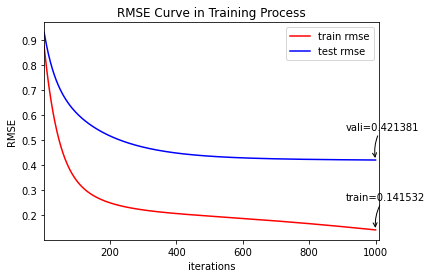

In [10]:
import matplotlib.pyplot as plt

# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color='r', label='train rmse')
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color='b', label='test rmse')
plt.legend()
plt.annotate(r'train=%f' % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.annotate(r'vali=%f' % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE Curve in Training Process')
plt.show()